In [1]:
from model import ModelWrapper, Trainer, ImageDataset

In [2]:
wrap = ModelWrapper() # model_name 

In [3]:
import os
from typing import List

def collect_image_paths(root_dir: str) -> List[str]:
    """
    Собирает все пути изображений в указанной папке и её подкаталогах.

    Параметры:
        root_dir (str): Корневая папка, в которой будут искаться изображения.

    Возвращает:
        List[str]: Список путей к изображениям.
    """
    image_paths = []
    for root, _, files in os.walk(root_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')):
                image_paths.append(os.path.join(root, file))
    return image_paths

In [4]:
paths = collect_image_paths(root_dir='./train_data_rkn/dataset')

In [5]:
import random
from typing import List, Tuple
from collections import defaultdict

def split_dataset(image_paths: List[str], val_ratio: float = 0.2) -> Tuple[List[str], List[str]]:
    """
    Перемешивает и равномерно разделяет пути изображений на тренировочную и валидационную выборки
    по каждому подкаталогу.

    Параметры:
        image_paths (List[str]): Список путей к изображениям.
        val_ratio (float): Доля данных, которая будет отведена под валидацию.

    Возвращает:
        Tuple[List[str], List[str]]: Тренировочная и валидационная выборки.
    """
    # Группируем изображения по подкаталогам
    grouped_paths = defaultdict(list)
    for path in image_paths:
        subdir = os.path.basename(os.path.dirname(path))
        grouped_paths[subdir].append(path)
    
    train_paths, val_paths = [], []
    
    # Для каждой группы перемешиваем и разделяем
    for paths in grouped_paths.values():
        random.shuffle(paths)
        val_size = int(len(paths) * val_ratio)
        val_paths.extend(paths[:val_size])
        train_paths.extend(paths[val_size:])
    
    # Перемешиваем данные снова, чтобы избавиться от последовательности по подкаталогам
    random.shuffle(train_paths)
    random.shuffle(val_paths)
    
    return train_paths, val_paths

In [6]:
train_paths, val_paths = split_dataset(paths)

In [7]:
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Пример изменения размера, если требуется
    transforms.ToTensor()
])

In [8]:
# Закомментить для всего датасета
# train_paths = train_paths[:1024]
# val_paths = val_paths[:256]

train_data = ImageDataset(image_paths=train_paths, transform = transform)
val_data = ImageDataset(image_paths=val_paths, transform = transform)

In [9]:
from torch.utils.data import DataLoader
batch_size = 16
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

In [10]:
visual_parameters = [p for p in wrap.model.vision_model.parameters() if p.requires_grad]
transformer_parameters = [p for p in wrap.model.text_model.parameters() if p.requires_grad]

param_groups = [ # Это для AdamW, лучше с этим его использовать
    {'params': transformer_parameters[:len(transformer_parameters)//2], 'lr': 1e-6},  # First half of the transformer
    {'params': transformer_parameters[len(transformer_parameters)//2:], 'lr': 3e-6},   # Second half of the transformer
    {'params': visual_parameters[:len(visual_parameters)//2], 'lr': 1e-6},  # First half of the vision transformer
    {'params': visual_parameters[len(visual_parameters)//2:], 'lr': 3e-6},   # Second half of the vision transformer
]
learning_rate = 5e-7
from torch.optim import AdamW
from adabelief_pytorch import AdaBelief

EPOCHS = 5
total_steps = len(train_dataloader) * EPOCHS
from torch.optim.lr_scheduler import OneCycleLR

# optimizer = AdamW(wrap.model.parameters(), lr=learning_rate, betas=(0.9, 0.995), eps=1e-6, weight_decay=1e-2)
optimizer = AdaBelief(wrap.model.parameters(), lr=learning_rate, eps=1e-16, betas=(0.9, 0.999), weight_decay=1e-2, weight_decouple=False, rectify=True, print_change_log = False)
scheduler = OneCycleLR(optimizer, max_lr=learning_rate, total_steps=total_steps, pct_start=0.1, anneal_strategy='linear')

Rectification enabled in AdaBelief


In [11]:
trainer = Trainer(
    model_wrapper=wrap,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    scheduler=scheduler
)

In [12]:
trainer.fit(EPOCHS)

Training:   0%|          | 0/967 [00:00<?, ?it/s]c:\Anaconda\envs\pip-torch\Lib\site-packages\transformers\models\clip\modeling_clip.py:540: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
Validating: 100%|██████████| 241/241 [01:18<00:00,  3.06it/s]


Epoch 1/5, Train Loss: 2.3297, Val Loss: 1.6357


Validating: 100%|██████████| 241/241 [01:19<00:00,  3.04it/s]


Epoch 2/5, Train Loss: 1.5155, Val Loss: 1.4520


Validating: 100%|██████████| 241/241 [01:22<00:00,  2.91it/s]


Epoch 3/5, Train Loss: 1.3956, Val Loss: 1.3710


Validating: 100%|██████████| 241/241 [01:20<00:00,  2.99it/s]


Epoch 4/5, Train Loss: 1.3382, Val Loss: 1.3336


Validating: 100%|██████████| 241/241 [01:19<00:00,  3.04it/s]


Epoch 5/5, Train Loss: 1.2921, Val Loss: 1.2807


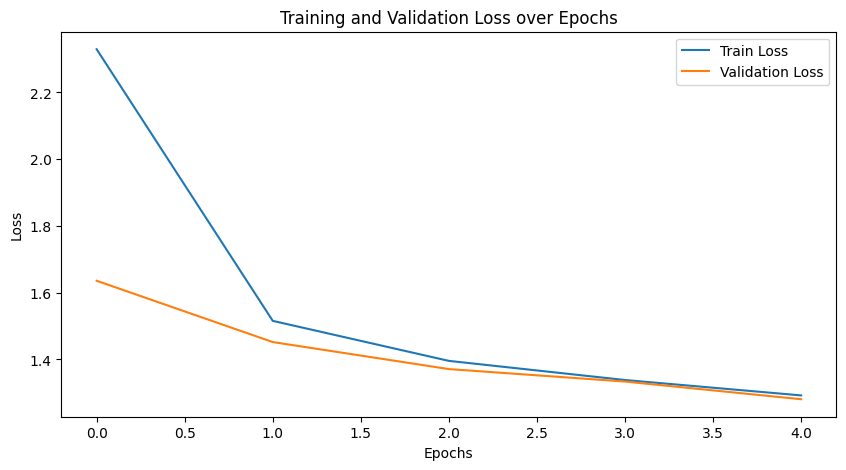

In [13]:
trainer.plot_losses()

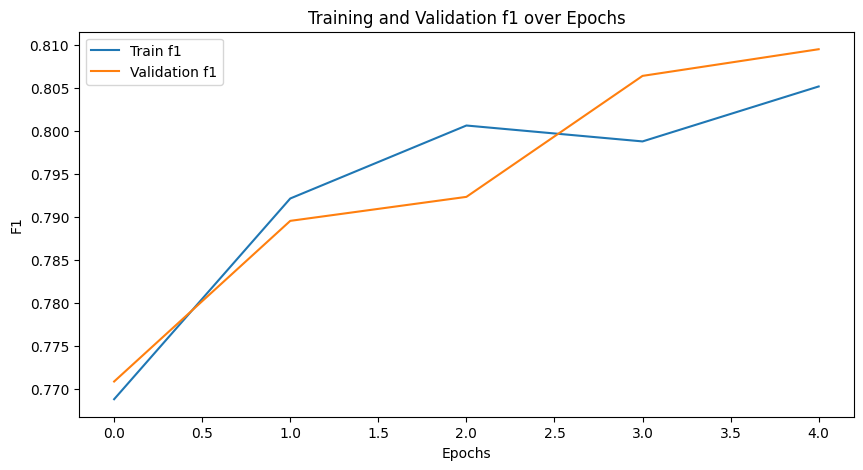

In [14]:
trainer.plot_f1()

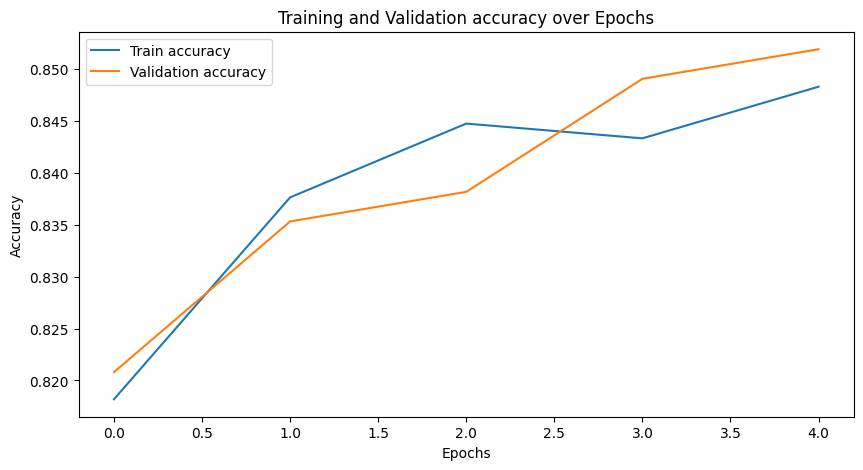

In [15]:
trainer.plot_acc()

In [16]:
trainer.model_wrapper.model.save_pretrained("./clip")